In [16]:
try:
    import luas
except ImportError:
    !git clone https://github.com/markfortune/luas.git
    %cd luas
    %pip install .
    %cd ..

try:
    import jaxoplanet
except ImportError:
    %pip install -q jaxoplanet

try:
    import pymc
except ImportError:
    %pip install -q pymc
    
try:
    import corner
except ImportError:
    %pip install -q corner

(PyMC Example)=

# An Introduction into PyMC

This notebook shows an example analysis of an archival data set from VLT/FORS2 using PyMC for inference.

In [17]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path
import logging

jax.config.update("jax_enable_x64", True)

logging.getLogger().setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

file_path = luas.__file__
path_to_luas_code = os.path.join(os.path.dirname(file_path)).split(os.sep)
path_to_sample_data = os.sep + os.path.join(*path_to_luas_code[:-2], "docs", "source", "tutorials", "sample_data", "WASP31b_FORS2_600B")

use_binned_data = False

if use_binned_data:
    x_t = np.load(os.path.join(path_to_sample_data, "x_t_binned.npy"))
    Y = np.load(os.path.join(path_to_sample_data, "Y_binned.npy"))
else:
    x_t = np.load(os.path.join(path_to_sample_data, "x_t.npy"))
    Y = np.load(os.path.join(path_to_sample_data, "Y.npy"))

x_l = np.load(os.path.join(path_to_sample_data, "x_l.npy"))
ld_coeff = np.load(os.path.join(path_to_sample_data, "ld_coeff.npy"))
ld_coeff_errs = 0.1 * np.ones_like(ld_coeff)

N_l = x_l.shape[-1]
N_t = x_t.shape[-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from luas import kernels
from luas import LuasKernel

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.power(10, 2*hp["h_CM"])*kernels.squared_exp(x_l1, x_l2, jnp.power(10, hp["l_l_CM"]))
    Kl += jnp.diag(jnp.power(10, 2*hp["h_WSS"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return kernels.squared_exp(x_t1, x_t2, jnp.power(10, hp["l_t"]))

def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.power(10, 2*hp["h_HFS"])*kernels.squared_exp(x_l1, x_l2, jnp.power(10, hp["l_l_HFS"]))
    if wn:
        Sl += jnp.diag(jnp.power(10, 2*hp["sigma"]))

    return Sl

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.shape[-1])
St_fn.decomp = "diag"

kernel = LuasKernel(Kl = Kl_fn, Kt = Kt_fn, Sl = Sl_fn, St = St_fn, use_stored_results = False)

23193.027819157724


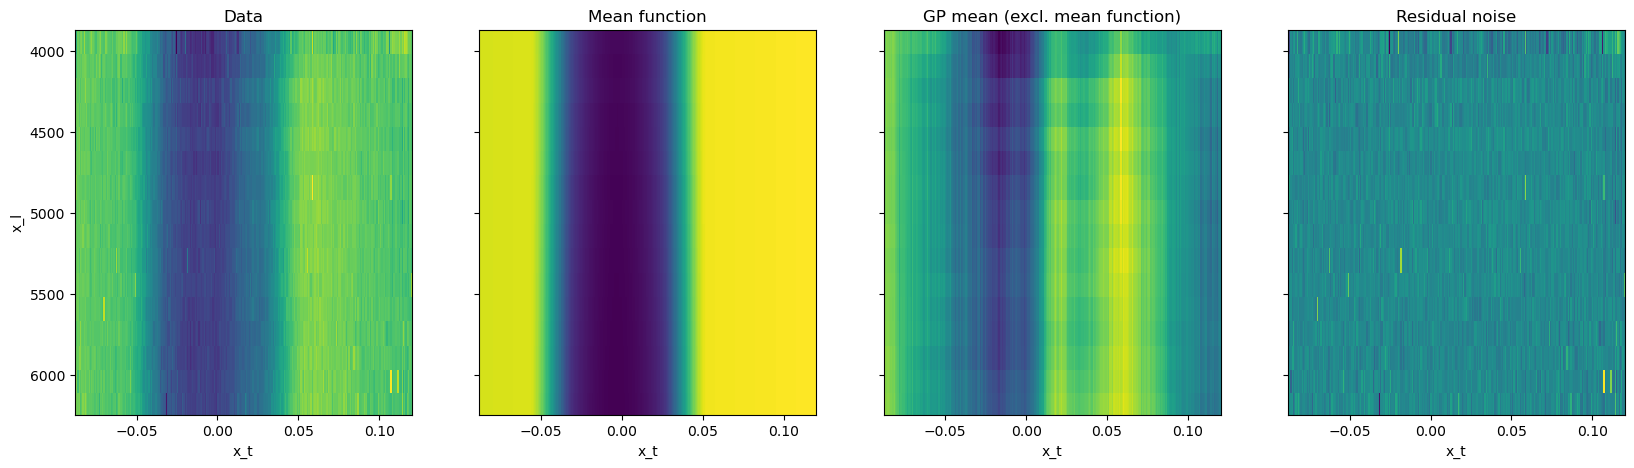

In [19]:
from luas import GP
from luas.exoplanet import transit_2D, ld_from_kipping, ld_to_kipping

u1, u2 = ld_to_kipping(ld_coeff[:N_l, 0], ld_coeff[:N_l, 1])

p_initial = {"T0":-0.0021*np.ones(1), "P":3.4059095*np.ones(1), "a":8.16*np.ones(1), "b":0.771*np.ones(1), "d":0.015*np.ones(N_l), "u1":u1, "u2":u2,
     "Foot":np.ones(N_l)*0.9995, "Tgrad":np.ones(N_l)*0.0002, "h_CM":1.5e-3*np.ones(1), "l_t":0.011*np.ones(1), "l_l_CM":10000.*np.ones(1), "sigma":1.2e-3*np.ones(N_l),
                  "h_WSS":2e-4*np.ones(N_l), "h_HFS":3e-4*np.ones(1), "l_l_HFS":1000.*np.ones(1)}

for par in ["h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS"]:
    p_initial[par] = np.log10(p_initial[par])

prior_values = {"a":8.19, "b":0.761}
prior_std = {"a":0.1, "b":0.018}

def logPrior(p):
    logPrior = -0.5*((p["a"] - prior_values["a"])/prior_std["a"])**2
    logPrior += -0.5*((p["b"] - prior_values["b"])/prior_std["b"])**2

    c1, c2 = ld_from_kipping(p["u1"], p["u2"])
    logPrior += (-0.5*((c1 - ld_coeff[:N_l, 0])/ld_coeff_errs[:N_l, 0])**2).sum()
    logPrior += (-0.5*((c2 - ld_coeff[:N_l, 1])/ld_coeff_errs[:N_l, 1])**2).sum()

    return logPrior.sum()

gp = GP(kernel, x_l, x_t, mf = transit_2D, logPrior = logPrior)

gp.plot(p_initial, Y)
print(gp.logP(p_initial, Y))

In [9]:
import pymc as pm
from copy import deepcopy
from luas.pymc_ext import LuasPyMC

param_bounds = {"T0":[np.array([-0.01]), np.array([0.01])],
                "d":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "u1":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "u2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "sigma":[np.array([-5.]*N_l), np.array([-2.]*N_l)],
                "h_WSS":[np.array([-6.]*N_l), np.array([-2.]*N_l)],
                "h_CM":[np.array([-6.]*1), np.array([-2.]*1)],
                "l_l_CM":[np.array([np.log10(np.diff(x_l).min())]), np.array([np.log10(50*(x_l.max() - x_l.min()))])],
                "h_HFS":[np.array([-6.]), np.array([-2.])],
                "l_l_HFS":[np.array([np.log10(np.diff(x_l).min())]), np.array([np.log10(50*(x_l.max() - x_l.min()))])]}


def transit_model(p_fixed, Y):
    
    with pm.Model() as model:

        var_dict = deepcopy(p_fixed)
        var_dict["T0"] = pm.Uniform('T0',         lower=param_bounds["T0"][0],   upper=param_bounds["T0"][1], shape=1)
        var_dict["d"] = pm.Uniform('d',         lower=param_bounds["d"][0],   upper=param_bounds["d"][1], shape=N_l)
        var_dict["h_CM"] =   pm.Uniform("h_CM", lower=param_bounds["h_CM"][0],      upper=param_bounds["h_CM"][1], shape=1)
        var_dict["l_l_CM"] = pm.Uniform("l_l_CM", lower = param_bounds["l_l_CM"][0], upper = param_bounds["l_l_CM"][1], shape=1)
        var_dict["h_HFS"] =   pm.Uniform("h_HFS", lower=param_bounds["h_HFS"][0],      upper=param_bounds["h_HFS"][1], shape=1)
        var_dict["l_l_HFS"] = pm.Uniform("l_l_HFS", lower = param_bounds["l_l_HFS"][0], upper = param_bounds["l_l_HFS"][1], shape=1)
        var_dict["h_WSS"] =  pm.Uniform('h_WSS',       lower=param_bounds["h_WSS"][0], upper=param_bounds["h_WSS"][1], shape=N_l)
        var_dict["sigma"] = pm.Uniform('sigma',     lower=param_bounds["sigma"][0], upper=param_bounds["sigma"][1], shape=N_l)
        var_dict["u1"] = pm.Uniform('u1',     lower=param_bounds["u1"][0], upper=param_bounds["u1"][1], shape=N_l)
        var_dict["u2"] = pm.Uniform('u2',     lower=param_bounds["u2"][0], upper=param_bounds["u2"][1], shape=N_l)

        var_dict["l_t"] = pm.Flat('l_t', shape=1)
        var_dict["a"] = pm.Flat('a', shape=1)
        var_dict["b"] = pm.Flat('b', shape=1)
        var_dict["Foot"] = pm.Flat('Foot', shape=N_l)
        var_dict["Tgrad"] = pm.Flat('Tgrad', shape=N_l)

        LuasPyMC("log_like", gp = gp, var_dict = var_dict, Y = Y)
        
    return model, var_dict


In [83]:
model, var_dict = transit_model(p_initial, Y)

# PyMC requires the dictionary of starting values to only include variables in the model
# So we must remove the period parameter P as we keep it fixed
p_pymc = deepcopy(p_initial)
del p_pymc["P"]

# Use PyMC's maximum posteriori optimisation method
map_estimate = pm.find_MAP(
    model = model,
    include_transformed = False,
    start = p_pymc,
    maxeval = 30000,
)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt = deepcopy(p_initial)
p_opt.update(map_estimate)

In [84]:
gp.logP(p_opt, Y)

DeviceArray(5398.6616611, dtype=float64)

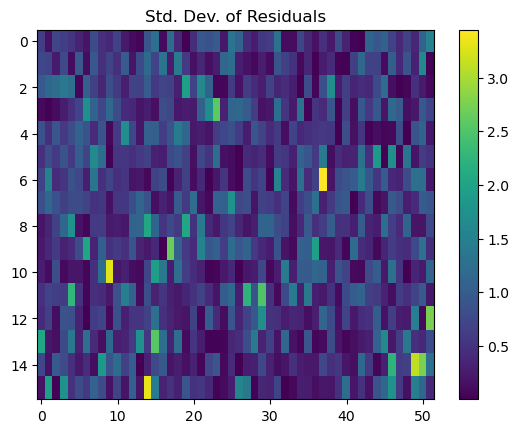

Outliers removed =  0


In [85]:
Y_clean = gp.sigma_clip(p_opt, Y, 4.)

In [86]:
model, var_dict = transit_model(p_opt, Y_clean)
map_estimate2 = pm.find_MAP(model = model, include_transformed = False, start = map_estimate, maxeval = 5000)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt2 = deepcopy(p_initial)
p_opt2.update(map_estimate2)

In [16]:
import pickle

def save_dict(dict_to_save, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

save_dict(p_opt2, os.path.join("sample_data", "p_opt2.pkl"))
np.save(os.path.join("sample_data", "Y_clean.npy"), Y_clean)

In [6]:
import pickle

def load_dict(filename):
    with open(filename, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

p_opt2 = load_dict(os.path.join("sample_data", "p_opt2.pkl"))
Y_clean = np.load(os.path.join("sample_data", "Y_clean.npy"))

In [15]:
cov_mat, ordered_param_list = gp.laplace_approx_with_bounds(p_opt2, Y_clean, param_bounds, fixed_vars = ["P"],
                                                            return_array = True, regularise = True, large = False)

Initial number of negative values on diagonal of covariance matrix = 21
Corresponding to parameters: {'d': DeviceArray([False, False,  True,  True,  True,  True,  True, False,
              True, False,  True, False, False,  True, False, False],            dtype=bool), 'h_WSS': DeviceArray([ True,  True, False, False, False, False, False, False,
             False, False, False,  True, False,  True, False, False],            dtype=bool), 'sigma': DeviceArray([False,  True,  True,  True, False,  True, False, False,
              True, False,  True,  True,  True,  True, False, False],            dtype=bool)}.
Remaining number of negative values = 8.


In [92]:
model, var_dict = transit_model(p_opt2, Y_clean)

NUTS_model_vars = [var_dict[par] for par in ordered_param_list]
step1 = pm.NUTS(NUTS_model_vars, scaling = cov_mat, is_cov = True, model = model)

idata = pm.sample(model = model, step = step1, initvals = map_estimate2, draws = 1000,
                          tune = 1000, chains = 2, cores = 1)

INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [Foot, T0, Tgrad, a, b, d, h_CM, h_HFS, h_WSS, l_l_CM, l_l_HFS, l_t, sigma, u1, u2]


/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

KeyboardInterrupt



Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l_t[0],-1.933755,0.041883,-2.005514,-1.859232,0.003506,0.002484,138.515353,131.057915,NaN
a[0],8.224942,0.095898,8.045793,8.390920,0.006304,0.004463,245.100861,149.699169,NaN
b[0],0.767093,0.008572,0.751569,0.782469,0.000648,0.000460,175.580626,94.806295,NaN
u1[0],0.612635,0.156852,0.387148,0.940408,0.008495,0.006220,346.165263,176.755742,NaN
u1[1],0.669332,0.135242,0.413034,0.907492,0.008260,0.005847,257.199179,181.816509,NaN
u1[2],0.670497,0.071344,0.552254,0.819491,0.004389,0.003120,260.488835,149.699169,NaN
u1[3],0.524635,0.063435,0.408397,0.644935,0.004042,0.002861,236.338774,177.700941,NaN
u1[4],0.589702,0.090975,0.443766,0.768988,0.005612,0.003973,247.717796,183.817764,NaN
u1[5],0.636942,0.080369,0.486147,0.778362,0.005225,0.003699,257.863552,170.804653,NaN
u1[6],0.466811,0.064037,0.355986,0.582138,0.004630,0.003279,176.316455,147.633538,NaN


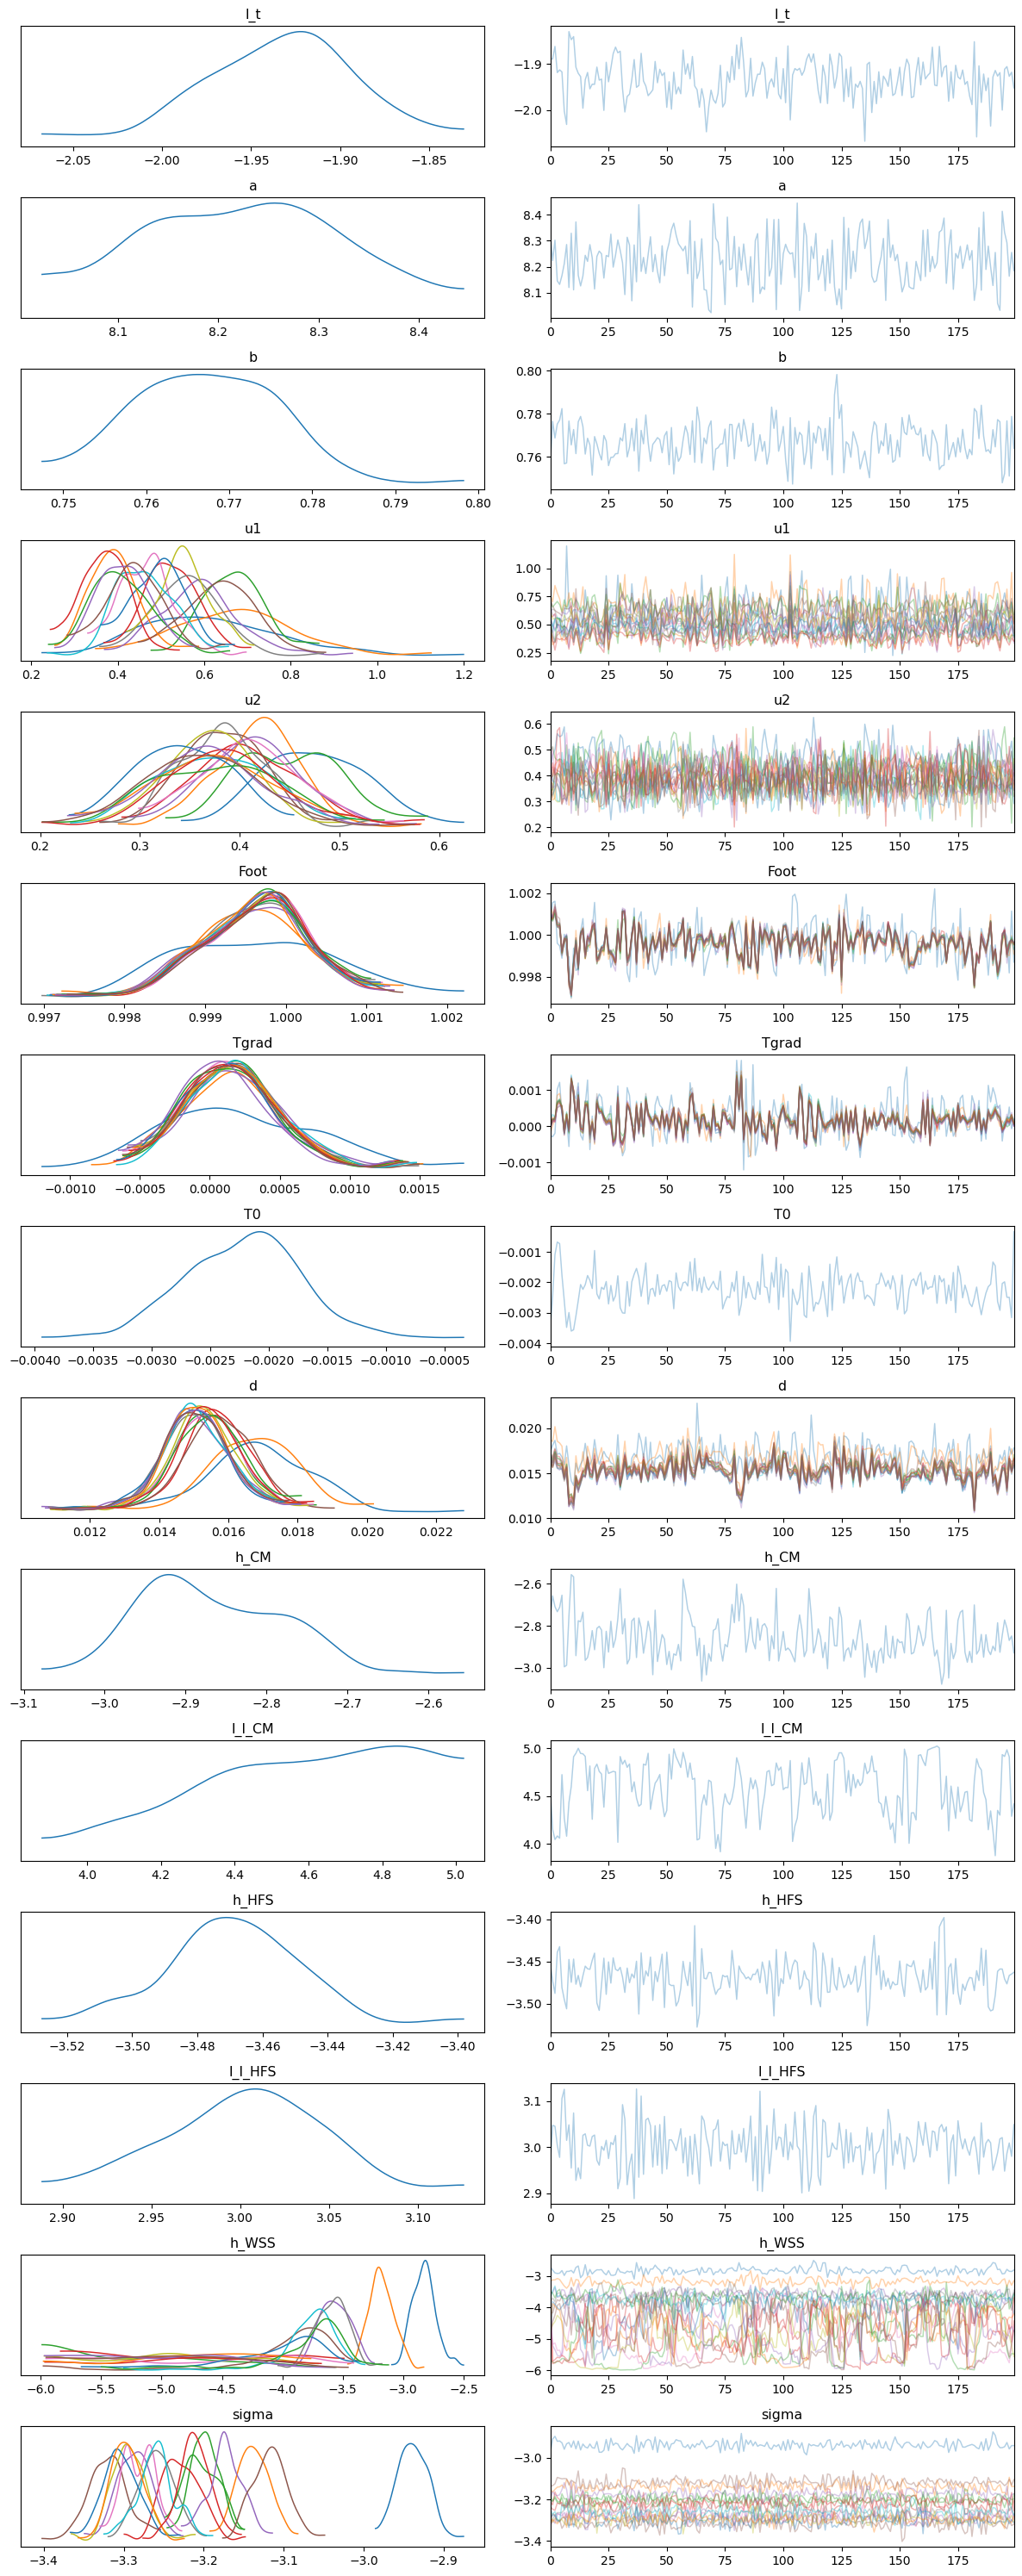

In [22]:
import arviz as az
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print a summary of the samples
df_summary = az.summary(idata, round_to = 6)

trace_plot = az.plot_trace(idata, divergences = None)
plt.tight_layout()

df_summary